# Training The Proposed SimpleNet Model
## Description of Notebook
The notebook contains code used for training the proposed SimpleNet model. 
The model classifies preprocessed retinal OCT scans into three categories: urgent referral, routine referral
and normal. **5-fold cross validation** was used to present an accurate estimate of the efficacy of the model 
on unseen data. The notebooks were run on the kaggle platform for training purposes. **Since the 5-folds
and initial weights of the convolutional neural net are random, the accuracies might not match with the accuracies
given in the publication.**

## Description of SimpleNet Model
In the publication, a small CNN architecture with 30,793 parameters is used as the
classifier. The proposed SimpleNet consists of four convolutional layers, two
batch normalization layers, two max-pooling layers, and a final fully connected
output layer consisting of three nodes with softmax activation function. The training process uses Adam as the optimizer with a learning rate of 0.001,
while the “categorical cross-entropy” cost function is used to train the output
layer. The training was performed in batches of 128 images per step.

### Table of Contents
* [1. Importing all modules](#1)
* [2. Loading train and test data](#2)
* [3. Generator Classes using Sequence class](#3)
* [4. Functions for building and loading the transfer learning model](#4)
* [5. Functions for training and cross-validation](#5)
* [6. Training the model](#6)
* [7. Performance metrics of proposed SimpleNet based model](#7)
* [8. Performance Comparison Graph of SimpleNet model against transfer learning based classification](#8)

<a id="1"></a>
### 1. Importing all modules

In [1]:
import os
import keras
from keras.models import Sequential
from scipy.misc import imread
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
import pandas as pd
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.utils import Sequence
from cv2 import * #Import functions from OpenCV
import cv2
import glob
from skimage.transform import resize
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import model_from_json
import json
from statistics import mean
from sklearn.utils import shuffle
import time

Using TensorFlow backend.


<a id="2"></a>
### 2. Loading train and test data
Training data is split randomly into 5 folds.


In [2]:
def kfold_data():
    img = glob.glob("../input/no-med-filt-60/no_median_filter_60_200/no_median_filter_60_200/train/CNV/*.jpeg");
    img = img + glob.glob("../input/no-med-filt-60/no_median_filter_60_200/no_median_filter_60_200/train/DME/*.jpeg");
    l = len(img);
    y = np.zeros((l,3))
    y[:,2] =1
    img = img + glob.glob("../input/no-med-filt-60/no_median_filter_60_200/no_median_filter_60_200/train/DRUSEN/*.jpeg");
    m = len(img);
    k = np.zeros((m-l,3));
    k[:,1] = 1;
    y = np.append(y,k, axis =0);
    img = img + glob.glob("../input/no-med-filt-60/no_median_filter_60_200/no_median_filter_60_200/train/NORMAL/*.jpeg");
    k = np.zeros((len(img)-m,3));
    k[:,0] = 1;
    y = np.append(y,k, axis =0);
    img, y = shuffle(img,y)
    img, y = shuffle(img,y)
    img, y = shuffle(img,y)
    img, y = shuffle(img,y)
    img, y = shuffle(img,y)

    from sklearn.model_selection import KFold
    ## Training with K-fold cross validation
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    kf.get_n_splits(img)

    X = np.array(img)
    y = np.array(y)
    np.savetxt('X'+'.out',X,fmt='%s')
    np.savetxt('y'+'.out',y)
    j=1
    for train_index, test_index in kf.split(img):
        trainData = X[train_index]
        testData = X[test_index]
        trainLabels = y[train_index]
        testLabels = y[test_index]
        np.savetxt('train_index'+'-'+str(j)+'.out',train_index)
        np.savetxt('test_index'+'-'+str(j)+'.out',test_index)
        j+=1



#reading test images, because can't use validation generator here, as that limilts the time
t_img = []

for images in glob.glob("../input/no-med-filt-60/no_median_filter_60_200/no_median_filter_60_200/test/CNV/*.jpeg"):
    n = resize(imread(images,0), (60, 200,1))
    t_img.append(n)
    
for images in glob.glob("../input/no-med-filt-60/no_median_filter_60_200/no_median_filter_60_200/test/DME/*.jpeg"):
    n = resize(imread(images,0), (60, 200,1))
    t_img.append(n)
    
l = len(t_img);
t_y = np.zeros((l,3))
t_y[:,2] =1
  
for images in glob.glob("../input/no-med-filt-60/no_median_filter_60_200/no_median_filter_60_200/test/DRUSEN/*.jpeg"):
    n = resize(imread(images,0), (60, 200,1))
    t_img.append(n)    

     
m = len(t_img);
k = np.zeros((m-l,3));
k[:,1] = 1;
t_y = np.append(t_y,k, axis =0);
    
    
for images in glob.glob("../input/no-med-filt-60/no_median_filter_60_200/no_median_filter_60_200/test/NORMAL/*.jpeg"):
    n = resize(imread(images,0), (60, 200,1))
    t_img.append(n)
    
k = np.zeros((len(t_img)-m,3));
k[:,0] = 1;
t_y = np.append(t_y,k, axis =0);

<a id="3"></a>
### 3. Generator Classes using Sequence class
Since our training dataset is large, we would use the Sequence class to help us feed images in batches for training.
Different generator classes are defined for training sets and validation sets.

In [3]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.n = len(image_filenames)

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx_min = idx*self.batch_size
        idx_max = np.amin([((idx+1)*self.batch_size),self.n])
        batch_x = self.image_filenames[idx_min:idx_max]
        batch_y = self.labels[idx_min:idx_max]
        X = np.array([
            resize(imread(file_name,0), (60, 200,1))
               for file_name in batch_x])
        y = np.array(batch_y)
        X, y = shuffle(X,y)
        return X,y
    
class My_valid_Generator(Sequence):

    def __init__(self, image_filenames, batch_size):
        self.image_filenames = image_filenames
        self.batch_size = batch_size
        self.n = len(image_filenames)

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx_min = idx*self.batch_size
        idx_max = np.amin([((idx+1)*self.batch_size),self.n])
        batch_x = self.image_filenames[idx_min:idx_max]
        X = np.array([
            resize(imread(file_name,0), (60, 200,1))
               for file_name in batch_x])
        return X

<a id="4"></a>
### 4. Functions for building and loading the transfer learning model

For each cross-validation build_model() builds the architecture of proposed SimpleNet model whereas load_ith_model() 
loads the ith cross-validation model from memory for testing and validation. 

The proposed model has just **30,793** parameters. 

In [4]:
def build_model():
    
    model = Sequential()
        
    model.add(Conv2D(filters = 20, kernel_size = (5,5), input_shape = (60,200,1), activation = 'relu'))
    model.add(Conv2D(filters = 20, kernel_size = (5,5), activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (4, 4)))
    
    
    model.add(Conv2D(filters = 40, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(filters = 30, kernel_size = (3,3), activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (4, 4)))
    

    model.add(Flatten())
    model.add(Dense(units = 3, activation = 'softmax'))

    #compile the model
    model.compile(optimizer=Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def load_ith_model(i):
    json_file = open('model-'+str(i)+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights('model-'+str(i)+'.h5')

    #compile the model
    model.compile(optimizer=Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model



<a id="5"></a>
### 5. Functions for training and cross-validation
For each cross-validation i, train_save_validate(i,X,y) trains the model, saves model-i and saves the validation performance
metrics on validation fold. 

In [5]:
def train_save_validate(i, X, y):
    
    batch_size = 128
    train_index = np.genfromtxt('train_index-'+str(i)+'.out').astype(int)
    test_index = np.genfromtxt('test_index-'+str(i)+'.out').astype(int)
    trainData = X[train_index]
    testData = X[test_index]
    trainLabels = y[train_index]
    testLabels = y[test_index]

    trainGenerator = My_Generator(trainData,trainLabels,batch_size)
    valGenerator = My_Generator(testData,testLabels,400)
    
    # we are doing one epoch at a time here so that we can see
    # validation accuracies after every epoch and get to see how it 
    # changes with each epoch
    for loop in range(1,11):
        if loop==1:
            model = build_model()
            model.summary()
        else:
            model = load_ith_model(i)#else ends
            
        history = model.fit_generator(
            generator = trainGenerator,
            steps_per_epoch=(len(trainLabels)//batch_size),
            epochs=1, verbose = 2, class_weight = [0.70596402, 4.19022748, 0.74357918], 
            validation_data = valGenerator, validation_steps = len(testLabels)//400)
        model_json = model.to_json()
        with open('model-'+str(i)+'.json', "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights('model-'+str(i)+'.h5')
            
    valGenerator = My_valid_Generator(testData,400)
    t_y = np.argmax(testLabels,axis=1)    
    ans = np.argmax(model.predict_generator(valGenerator),axis =1)
    
    # performance metrics  
    return performance_metrics(t_y,ans)
    

**perfromance_metrics()** derives all performance measures from the confusion matrix whereas **print_performance_average_each_model()** prints the validation metrics in a readable format.

In [6]:
def performance_metrics(t_y,ans):
    acc = accuracy_score(t_y,ans)
    target_names = ['CLass Normal', 'CLass Early', 'Class Late']
    cm = confusion_matrix(t_y, ans) 
    sens0 = cm[0,0]/(cm[0,0]+cm[0,1]+cm[0,2])
    spec0 = (cm[1,1]+cm[1,2]+cm[2,1] +cm[2,2])/((cm[1,1]+cm[1,2]+cm[2,1] +cm[2,2])+(cm[1,0]+cm[2,0]))

    sens1 = cm[1,1]/(cm[1,0]+cm[1,1]+cm[1,2])
    spec1 = (cm[0,0]+cm[2,0]+cm[0,2] +cm[2,2])/((cm[0,0]+cm[2,0]+cm[0,2] +cm[2,2])+(cm[0,1]+cm[2,1]))

    sens2 = cm[2,2]/(cm[2,0]+cm[2,1]+cm[2,2])
    spec2 = (cm[0,0]+cm[0,1]+cm[1,0] +cm[1,1])/((cm[0,0]+cm[0,1]+cm[1,0] +cm[1,1])+(cm[0,2]+cm[1,2]))
  
    rep=classification_report(t_y, ans, target_names=target_names, digits = 4, labels=range(0,3),output_dict=True)
    return [acc,sens0,spec0,sens1,spec1,sens2,spec2],cm,rep

def print_performance_average_each_model(p,i):
    a = list(p[i][2].keys())
    b = list(p[i][2][a[0]].keys())

    s = np.zeros(7)
    pn = 0
    pe = 0
    pl =0
    fn =0
    fe = 0
    fl = 0
    rn = 0
    re = 0
    rl = 0
    for j in range(i,i+1):
        s = s + p[j][0]
        pn = pn +  p[j][2][a[0]][b[0]]
        pe = pe +  p[j][2][a[1]][b[0]]
        pl = pl +  p[j][2][a[2]][b[0]]
        fn = fn + p[j][2][a[0]][b[2]]
        fe = fe + p[j][2][a[1]][b[2]]
        fl = fl +  p[j][2][a[2]][b[2]]
        rn = rn +  p[j][2][a[0]][b[1]]
        re = re +  p[j][2][a[1]][b[1]]
        rl = rl +  p[j][2][a[2]][b[1]]
    print("\n\n###### Metrics for Fold ",i, " ######" )
    print('\nacc = ',round(s[0]*100,2))
    print("              sensitivity  specificity      precision      f1-score")
    print('\nClass Normal: ',round(s[1]*100,2), ",       ", round(s[2]*100,2), ",       ", round(pn*100,2),",       ", round(fn*100,2))
    print('\nClass Early:  ',round(s[3]*100,2), ",       ", round(s[4]*100,2), ",       ", round(pe*100,2),",       ", round(fe*100,2))
    print('\nClass Late:   ',round(s[5]*100,2), ",       ", round(s[6]*100,2), ",       ", round(pl*100,2),",       ", round(fl*100,2))

    print('\n\n##### Average Performance Metrics for Fold ', i, ' #####')
    avg_prec = round(p[j][2][a[5]][b[0]]*100,2)
    avg_sens = round(np.sum([s[1]*p[j][2][a[0]][b[3]],
                      s[3]*p[j][2][a[1]][b[3]],
                      s[5]*p[j][2][a[2]][b[3]]])*(100/p[j][2][a[5]][b[3]]),2)
    avg_spec = round(np.sum([s[2]*p[j][2][a[0]][b[3]],
                      s[4]*p[j][2][a[1]][b[3]],
                      s[6]*p[j][2][a[2]][b[3]]])*(100/p[j][2][a[5]][b[3]]),2)
    avg_f1 = round(p[j][2][a[5]][b[2]]*100,2)
    acc = round(s[0]*100,2)
    print('\nprecision: ',avg_prec,'sensitivity: ',avg_sens, ", specificity: ",avg_spec, ", f1-score: ", avg_f1)
    return [avg_prec, avg_sens, avg_spec, avg_f1, acc]


 <a id="6"></a>
### 6. Training the proposed SimpleNet model
This cell is not executed in this notebook as each training will yield different results. Kindly send me an email if you need the trained weights used in the publication.

In [7]:
valid_perf = {}
kfold_data()
X = np.genfromtxt('X.out', dtype='unicode')
y = np.genfromtxt('y.out')
valid_perf = {}
for i in range(1,6):
    print("\n====== K Fold Validation step => %d/%d =======" % (i,5))
    valid_perf[i]= train_save_validate(i,X,y)


====== K Fold Validation step => 1/5 =======
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 196, 20)       520       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 192, 20)       10020     
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 192, 20)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 192, 20)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 48, 20)        0         
__________________________________________

<a id="7"></a>
### 7. Performance metrics of proposed SimpleNet Model Architecture



In [8]:
###kfold for simple

simperf = np.zeros(5)

for i in range(1,6):
    simperf += print_performance_average_each_model(valid_perf,i)
simperf = simperf/5
print('\n#### AVERAGE PERFORMANCE OVER ALL FOLDS ####\n\n\nprecision: ',round(simperf[0],2),'sensitivity: ',round(simperf[1],2), ", specificity: ",round(simperf[2],2), ", f1-score: ", round(simperf[3],2))   
print('\n[',round(simperf[0],2),', ',round(simperf[1],2), ", ",round(simperf[2],2), ", ", round(simperf[3],2),"]")   

print('\n overall accuracy of model = ', round(simperf[4],2))



###### Metrics for Fold  1  ######

acc =  95.9
              sensitivity  specificity      precision      f1-score

Class Normal:  98.04 ,        97.47 ,        97.22 ,        97.63

Class Early:   75.97 ,        99.03 ,        87.3 ,        81.24

Class Late:    97.25 ,        96.62 ,        95.85 ,        96.55


##### Average Performance Metrics for Fold  1  #####

precision:  95.81 sensitivity:  95.9 , specificity:  97.22 , f1-score:  95.82


###### Metrics for Fold  2  ######

acc =  95.73
              sensitivity  specificity      precision      f1-score

Class Normal:  97.97 ,        97.55 ,        97.24 ,        97.6

Class Early:   80.44 ,        98.52 ,        82.58 ,        81.49

Class Late:    96.14 ,        97.08 ,        96.45 ,        96.29


##### Average Performance Metrics for Fold  2  #####

precision:  95.7 sensitivity:  95.73 , specificity:  97.42 , f1-score:  95.72


###### Metrics for Fold  3  ######

acc =  95.92
              sensitivity  specificity      


<a id="8"></a>
### 8. Performance Comparison Graph of SimpleNet model against transfer learning based classification

Graph shows performance metrics of the proposed SimpleNet model against transfer learning based classification methodology according to 5-fold cross-validation on preprocessed data


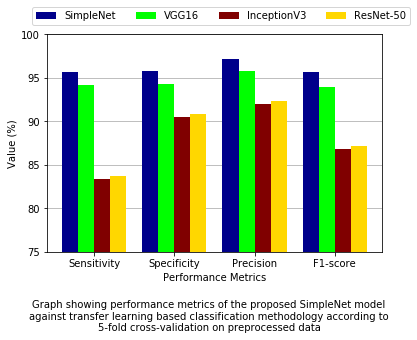

In [9]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111)

caption = "Graph showing performance metrics of the proposed SimpleNet model\nagainst transfer learning based classification methodology according to\n5-fold cross-validation on preprocessed data"
[ 95.67 ,  95.72 ,  97.12 ,  95.63 ]
[ 94.15 ,  94.25 ,  95.71 ,  93.89 ]
[ 83.37 ,  90.46 ,  92.0 ,  86.74 ]
[ 83.68 ,  90.86 ,  92.28 ,  87.12 ]
plt.grid(True, axis = 'y', alpha = 1,zorder = 0)
ax.bar([-0.3,0.7,1.7,2.7],[ 95.67 ,  95.72 ,  97.12 ,  95.63 ],width=0.2,color='darkblue',label='SimpleNet',align='center', zorder = 3)
ax.bar([-0.1,0.9,1.9,2.9],[ 94.15 ,  94.25 ,  95.71 ,  93.89 ],width=0.2,color='lime',label='VGG16',align='center', zorder = 3)
ax.bar([0.1,1.1,2.1,3.1], [ 83.37 ,  90.46 ,  92.0 ,  86.74 ],width=0.2,color='maroon',label='InceptionV3',align='center', zorder = 3)
ax.bar([0.3,1.3,2.3,3.3], [ 83.68 ,  90.86 ,  92.28 ,  87.12 ],width=0.2,color='gold',label='ResNet-50',align='center', zorder = 3)

ax.set_xlabel('Performance Metrics');
ax.set_ylabel('Value (%)');
plt.xticks(range(0,4),['Sensitivity','Specificity','Precision', 'F1-score'])

fig.text(.5, -.15, caption, ha='center')

ax.set_ylim([75,100])
plt.legend(bbox_to_anchor=(1.1, 1.15), ncol = 4)

plt.draw()
fig.savefig('comparison.png', bbox_inches='tight')

